# En France, le député assidu présente-t-il un profil type ? 

Alors que la société française se caractérise par une grande défiance de la population vis-à-vis de ses élus et responsables politiques, nous nous pencherons dans ce projet sur la question de l'assiduité des députés au cours de leur mandat. Nous verrons notamment grâce à différents outils (boîtes de Tukey, matrice de nuages de points, analyse en composantes principales, clustering, régression linéaire...) si l'on peut dresser un portrait type pour caractériser le député assidu ou absentéiste. 

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## I. Récupération et préparation des données

### 1. Importation des données

#### 1.1 Choix de la base de données

On récupère sur le site citoyen nosdeputes.fr une base de données synthétisant l'activité parlementaire sur les 12 derniers mois. Pour chaque député, cette table, que nous avons convertie au format .tsv, contient des informations relatives à son état civil, à la circonscription dont il est le représentant, à son éventuel parti politique et surtout à son travail parlementaire (semaines de présence à l'Assemblée nationale, rédaction de rapports, participation à des commissions...).

In [2]:
# Conversion du fichier tsv en DataFrame.
df = pd.read_csv("../Données/nosdeputes.fr_synthese_2020-10-24.tsv", sep='\t')
df

,id,nom,nom_de_famille,prenom,sexe,date_naissance,lieu_naissance,num_deptmt,nom_circo,num_circo,...,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales
0,32,Damien Abad,Abad,Damien,H,1980-04-05,Nîmes (Gard),01,Ain,5,...,253,307,19,1736,63,0,0,25,38,9
1,43,Caroline Abadie,Abadie,Caroline,F,1976-09-07,Saint-Martin-d'Hères (Isère),38,Isère,8,...,17,8,14,362,196,0,0,3,3,0
2,493,Jean-Félix Acquaviva,Acquaviva,Jean-Félix,H,1973-03-19,Bastia (Haute-Corse),2B,Haute-Corse,2,...,109,9,186,2309,89,0,0,4,22,3
3,152,Lénaïck Adam,Adam,Lénaïck,H,1992-02-19,Saint Laurent du Maroni (Guyane),973,Guyane,2,...,3,0,15,581,175,0,0,4,1,0
4,234,Damien Adam,Adam,Damien,H,1989-06-28,Orléans (Loiret),76,Seine-Maritime,1,...,24,7,74,687,225,0,0,4,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,26,Martine Wonner,Wonner,Martine,F,1964-03-27,Hayange (Moselle),67,Bas-Rhin,4,...,61,6,249,1581,157,0,0,3,14,3
535,215,Hubert Wulfranc,Wulfranc,Hubert,H,1956-12-17,Rouen (Seine-Maritime),76,Seine-Maritime,3,...,211,143,895,2776,70,0,0,8,35,16
536,130,Hélène Zannier,Zannier,Hélène,F,1972-09-19,Saint-Avold (Moselle),57,Moselle,7,...,9,3,25,475,214,0,0,4,12,0
537,31,Jean-Marc Zulesi,Zulesi,Jean-Marc,H,1988-06-06,Marseille (Bouches-du-Rhône),13,Bouches-du-Rhône,8,...,40,37,105,1111,279,0,0,4,52,4


#### 1.2 Complétion de la base de donnée à l'aide de webscraping

Ce jeu de données est plutôt complet, mais il lui manque une variable qui pourrait nous intéresser pour notre étude : le statut du député (sortant, élu pour la première fois ou ancien député).

Nous allons donc compléter la table avec la variable "statut" du tableau disponible sur la page http://www2.assemblee-nationale.fr/elections/liste/2017/resultats/RESULTAT.

In [3]:
# On récupère le code source de la page afin d'en extraire le tableau
from urllib import request
import bs4

request_text = request.urlopen("http://www2.assemblee-nationale.fr/elections/liste/2017/resultats/RESULTAT").read()
page = bs4.BeautifulSoup(request_text, "html")
tableau_html = page.find("table") # on extrait le tableau d'intérêt de la page html

Nous avons récupéré le code html du tableau, récupérons maintenant ses entêtes.

In [4]:
entetes = tableau_html.find('thead')
entetes = entetes.find('tr')
entetes = entetes.find_all('th')
entetes = [entete.text.strip() for entete in entetes]
print(entetes)

['Civ.', 'Nom', 'Prénom', 'Département', 'Circ.', 'Statut', 'Tour', 'Nuance']


Puis complétons un dictionnaire avec ses lignes et transformons le en data frame.

In [33]:
dict_tableau = {}
for entete in entetes:
    dict_tableau[entete] = []

corps_tableau = tableau_html.find('tbody')
lignes_tableau = corps_tableau.find_all('tr')
for ligne in lignes_tableau:
    colonnes = ligne.find_all('td')
    for i, element in enumerate(colonnes):
        dict_tableau[entetes[i]].append(element.text.strip())

df2 = pd.DataFrame.from_dict(dict_tableau)

Conservons uniquement les variables "Nom", "Prénom" et "Statut" et convertissons la casse des modalités, dans l'optique de les comparer avec l'autre table.

In [34]:
df2 = df2[["Nom", "Prénom", "Statut"]]
df2["Nom"] = df2["Nom"].str.lower()
df2["Prénom"] = df2["Prénom"].str.lower()
df2["Statut"] = df2["Statut"].str.lower()
df2

,Nom,Prénom,Statut
0,abad,damien,sortant
1,abadie,caroline,elue pour la 1ere fois
2,abba,bérangère,elue pour la 1ere fois
3,acquaviva,jean-félix,elu pour la 1ere fois
4,adam,lénaïck,elu pour la 1ere fois
...,...,...,...
572,wonner,martine,elue pour la 1ere fois
573,wulfranc,hubert,elu pour la 1ere fois
574,zannier,hélène,elue pour la 1ere fois
575,zulesi,jean-marc,elu pour la 1ere fois


On constate que notre table webscrappée comporte plus de députés : il nous faut éliminer les députés qui ne sont pas dans la première table avant de lui ajouter la variable "Statut".

In [43]:
df["Nom"] = df["nom_de_famille"].str.lower()
df["Prénom"] = df["prenom"].str.lower()
df_diff = pd.concat([df[["Nom","Prénom"]],df2[["Nom","Prénom"]]]).drop_duplicates(keep=False)
list(df_diff["Nom"])

['atger',
 'baudu',
 'brial',
 'brindeau',
 'chouat',
 'claireaux',
 'cloarec-le nabour',
 'courson (de)',
 'courson (de)',
 'dubré-chirat',
 'dufeu',
 'ganay (de)',
 'gipson',
 'julien-laferrière',
 'kéclard-mondésir',
 'la raudière (de)',
 'la verpillière (de)',
 'lainé',
 'lakrafi',
 'lasserre',
 'lavergne (de)',
 'lemoine',
 'loiseau',
 'lorho',
 'pételle',
 'poudroux',
 'provendier',
 'rugy (de)',
 'saint-paul',
 'sarnez (de)',
 'savignat',
 'temmerman (de)',
 'thiériot',
 'tolmont',
 'vanceunebrock',
 'vaucouleurs (de)',
 'venteau',
 'victory',
 'abba',
 'aliot',
 'andré',
 'attal',
 'azerot',
 'bareigts',
 'bello',
 'bompard',
 'bouillon',
 'bourguignon',
 'boyer',
 'carvounas',
 'castaner',
 'cesarini',
 'cloarec',
 'collard',
 'darrieussecq',
 'de courson',
 'de courson',
 'de ganay',
 'de la raudière',
 'de la verpillière',
 'de lavergne',
 'de montchalin',
 'de rugy',
 'de sarnez',
 'de temmerman',
 'de vaucouleurs',
 'demilly',
 'djebbari',
 'dubos',
 'dubre-chirat',
 'dufe

### 2. Nettoyage des données 

On commence par analyser les variables présentes dans la base afin de sélectionner celles que nous pouvons éliminer dans le cadre de notre étude. 

In [3]:
df.columns # On affiche la liste des variables.

Index(['id', 'nom', 'nom_de_famille', 'prenom', 'sexe', 'date_naissance',
       'lieu_naissance', 'num_deptmt', 'nom_circo', 'num_circo',
       'mandat_debut', 'mandat_fin', 'ancien_depute', 'groupe_sigle',
       'parti_ratt_financier', 'sites_web', 'emails', 'anciens_mandats',
       'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug',
       'url_nosdeputes', 'url_nosdeputes_api', 'nb_mandats', 'twitter',
       'semaines_presence', 'commission_presences', 'commission_interventions',
       'hemicycle_interventions', 'hemicycle_interventions_courtes',
       'amendements_proposes', 'amendements_signes', 'amendements_adoptes',
       'rapports', 'propositions_ecrites', 'propositions_signees',
       'questions_ecrites', 'questions_orales'],
      dtype='object')

In [4]:
# On retire les variables que l'on juge inutiles pour notre étude.
df_new = df.drop(['id', 'nom_de_famille', 'prenom', 'lieu_naissance',
              'mandat_debut', 'mandat_fin', 'ancien_depute', 'sites_web',
              'emails', 'anciens_mandats', 'place_en_hemicycle', 'url_an',
              'id_an', 'slug', 'url_nosdeputes', 'url_nosdeputes_api', 'twitter'], axis=1)

On crée désormais une variable âge à partir de la variable date_naissance, en considérant que l'âge des députés est arrêté au 31 décembre 2020. Cela va nous permettre de répartir les députés en tranches d'âge de façon à analyser l'influence de l'âge sur l'assiduité. 

In [5]:
df_new['age'] = 0 # On initialise à 0 la valeur de la variable age pour chaque individu.
for i in range(len(df_new)) :
    df_new['age'][i] = 2020 - int((df_new.iloc[i,2])[0:4]) 
    # On calcule la différence entre l'année actuelle et l'année de naissance de chaque député.

df_new = df_new.sort_values("age") # On réordonne la base dans l'ordre croissant de l'âge des députés. 

# On répartit maintenant les députés dans différentes tranches d'âge. 
df_new['tranche_age'] = 0
for i in range(len(df_new)) :
    if 20 <= df_new['age'][i] < 30 :
        df_new['tranche_age'][i] = '20-30 ans'
    if 30 <= df_new['age'][i] < 40 :
        df_new['tranche_age'][i] = '30-40 ans'
    if 40 <= df_new['age'][i] < 50 :
        df_new['tranche_age'][i] = '40-50 ans'
    if 50 <= df_new['age'][i] < 60 :
        df_new['tranche_age'][i] = '50-60 ans'
    if 60 <= df_new['age'][i] < 70 :
        df_new['tranche_age'][i] = '60-70 ans'
    if df_new['age'][i] >= 70 :
        df_new['tranche_age'][i] = '+ de 70 ans'

On poursuit le nettoyage en remplacant la modalité "0" de la variable profession par la modalité "Aucune", pour des questions de lisibilité.  

In [6]:
for i in range(len(df_new)) :
    if df_new['profession'][i] == '0' :
        df_new['profession'][i] = 'Aucune'
df_new['profession'].head()

139                                 Juriste
383                                  Aucune
3      Cadre supérieur (entreprises privée)
241                    Conseiller juridique
298     Agriculteur-propriétaire exploitant
Name: profession, dtype: object

Par webscraping, on récupère désormais un tableau permettant de savoir si le député est un sortant, et on complète alors notre jeu de données. 

In [7]:
# à faire

## II. Analyse descriptive

On procède à une analyse descriptive des données afin d'identifier les premières grandes tendances qui guideront notre travail. Les boîtes à moustaches (ou boîtes de Tukey, ou boxplots en anglais) permettent par exemple d'étudier les statistiques liées aux semaines de présence des députés à l'Assemblée nationale, en distinguant selon le sexe, le parti politique ou encore l'âge. On utilise ici la librairie seaborn. 

Text(0.5, 1.0, 'Boxplot représentant le nombre de semaines de présence des députés')

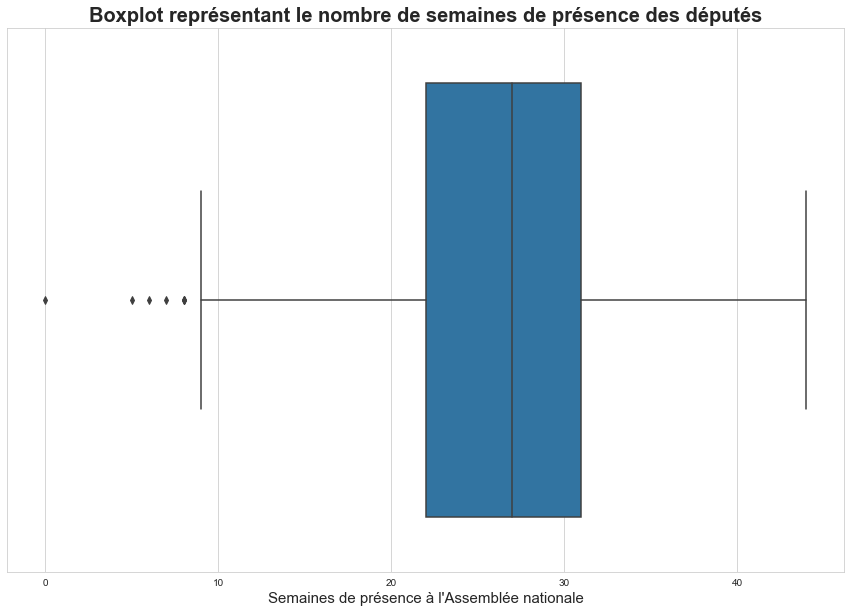

In [8]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.boxplot(x=df_new["semaines_presence"])
plt.xlabel("Semaines de présence à l'Assemblée nationale",size=15)
plt.title("Boxplot représentant le nombre de semaines de présence des députés",size=20,fontweight='bold')

Text(0.5, 1.0, 'Boxplot représentant le nombre de semaines de présence des députés en fonction de leur sexe')

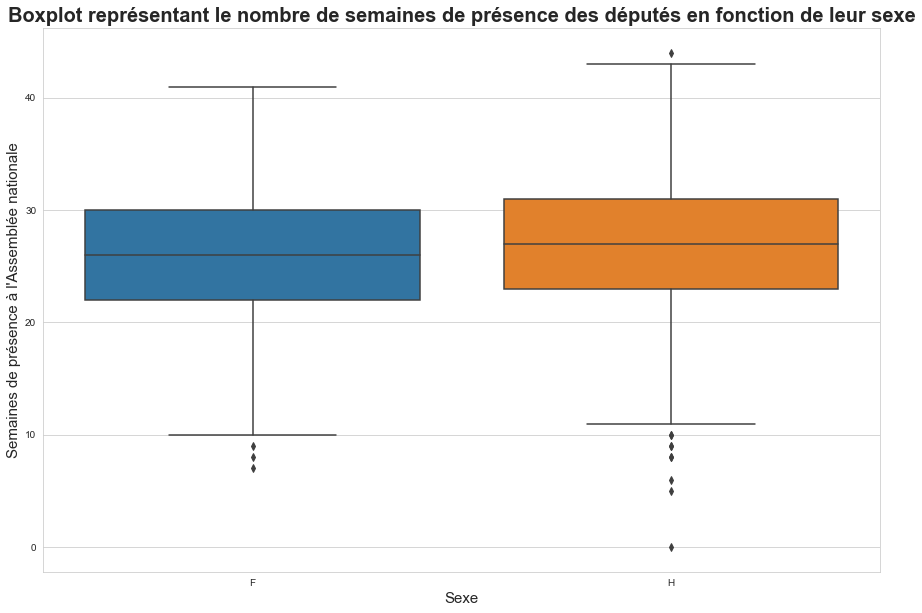

In [9]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="sexe", y="semaines_presence", data=df_new)
plt.xlabel("Sexe",size=15)
plt.ylabel("Semaines de présence à l'Assemblée nationale",size=15)
plt.title("Boxplot représentant le nombre de semaines de présence des députés en fonction de leur sexe",size=20,fontweight='bold')

Text(0.5, 1.0, 'Boxplot représentant le nombre de semaines de présence des députés en fonction de leur parti')

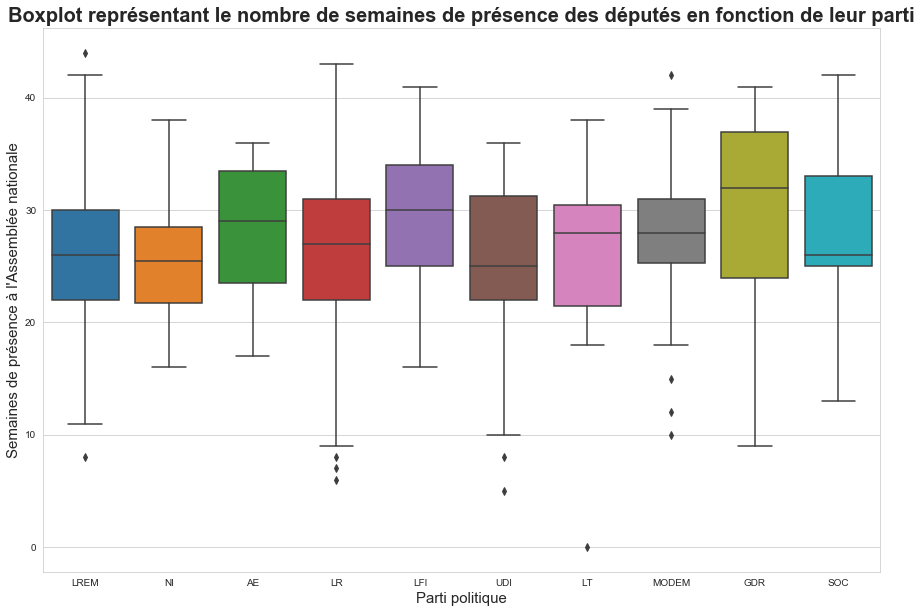

In [10]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="groupe_sigle", y="semaines_presence", data=df_new)
plt.xlabel("Parti politique",size=15)
plt.ylabel("Semaines de présence à l'Assemblée nationale",size=15)
plt.title("Boxplot représentant le nombre de semaines de présence des députés en fonction de leur parti",size=20,fontweight='bold')

Text(0.5, 1.0, 'Boxplot représentant le nombre de semaines de présence des députés en fonction de leur âge')

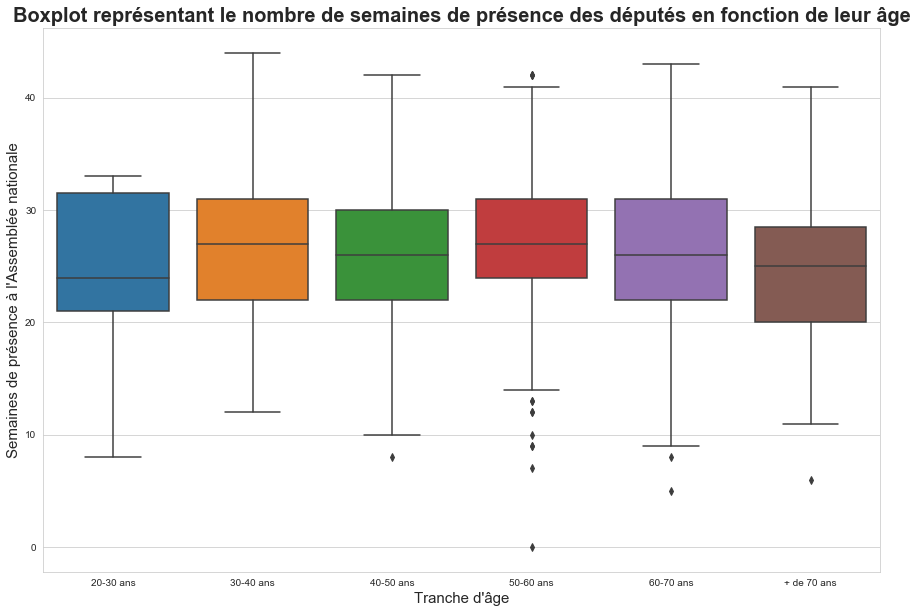

In [11]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="tranche_age", y="semaines_presence", data=df_new)
plt.xlabel("Tranche d'âge",size=15)
plt.ylabel("Semaines de présence à l'Assemblée nationale",size=15)
plt.title("Boxplot représentant le nombre de semaines de présence des députés en fonction de leur âge",size=20,fontweight='bold')

L'observation de ces boîtes à moustaches donne à voir quelques premières tendances :
- certains députés se démarquent de l'immense majorité des autres députés par un très fort absentéisme, comme le montrent les valeurs extrêmes du premier graphique ;
- globalement, les hommes sont légèrement plus présents à l'Assemblée nationale que les femmes ;
- il y a d'assez grandes disparités entre les différents partis ;
- les députés les plus âgés semblent être les moins assidus, mais les plus jeunes présentent la médiane la plus faible ;
- les 50-60 ans sont visiblement la génération la plus assidue.

## Prochaines étapes : 
- trouver base avec variable "sortant", webscraper et joindre les deux bases
- compléter avec d'autres stats desc (carte ? autre graphique ?)
- normaliser les données, puis réaliser la matrice de corrélation graphique / scatter-plot
- déterminer variables intéressantes pour l'ACP
- construire un score d'assiduité (réfléchir aux pondérations)
- k-means clustering
- régression linéaire

## Calcul du score d'assiduité

On cherche désormais à établir un score pour déterminer le degré d'activité d'un député, celui s'appuie sur une combinaison linéaire des variables d'activité proposés et pas seulement sur le nombre de présences. En effet, il semble évident que la rédaction d'un rapport, les interventions dans l'hémicycle ou encore les questions posées sont des éléments manifestant une implication importante du député dans l'exercice de sa tâche. La difficulté réside ici dans le fait qu'il faut habilement pondérer le poids des variables, en majorant le poids des activités individuelles au détriment des actions collectives. On crée des variables intermédiaires portant sur les scores de présence, de participation et de proposition. 

In [12]:
# A remonter plus haut dans le notebook quand on aura validé la formule ; il faudra modifier les boxplots notamment avec la nouvelle variable score_assiduite
# On procède à un df.describe() sur les variables d'activité, on va s'appuyer sur les médianes de chacune pour estimer le poids qu'on leur donnera dans le score d'assiduité individuel.
df[['semaines_presence', 'commission_presences', 'commission_interventions',
       'hemicycle_interventions', 'hemicycle_interventions_courtes',
       'amendements_proposes', 'amendements_signes', 'amendements_adoptes',
       'rapports', 'propositions_ecrites', 'propositions_signees',
       'questions_ecrites', 'questions_orales']].describe()

,semaines_presence,commission_presences,commission_interventions,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,26.476809,37.935065,33.966605,92.727273,130.925788,197.615955,1386.888683,149.530612,0.107607,0.231911,5.868275,16.346939,2.942486
std,6.972125,19.484468,58.794257,196.206471,638.135518,508.672588,1399.696540,76.949366,0.360088,0.670697,5.674840,15.917429,3.176124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,24.000000,5.000000,11.000000,2.000000,14.000000,508.500000,85.500000,0.000000,0.000000,3.000000,3.000000,1.000000
50%,27.000000,34.000000,15.000000,28.000000,9.000000,42.000000,716.000000,159.000000,0.000000,0.000000,4.000000,11.000000,2.000000
75%,31.000000,49.000000,35.500000,89.000000,49.500000,108.500000,1581.000000,203.000000,0.000000,0.000000,6.000000,26.000000,4.000000
max,44.000000,111.000000,500.000000,1938.000000,6731.000000,2887.000000,7434.000000,503.000000,3.000000,6.000000,37.000000,64.000000,18.000000


In [13]:
df_new['score_presence'] = 3*df_new['semaines_presence'] + 2*df_new['commission_presences']
df_new['score_presence'].describe()

count    539.000000
mean     155.300557
std       56.276853
min        0.000000
25%      115.500000
50%      153.000000
75%      190.500000
max      351.000000
Name: score_presence, dtype: float64

In [14]:
df_new['score_participation'] = 2*df_new['commission_interventions'] + df_new['hemicycle_interventions'] + 3*df_new['hemicycle_interventions_courtes'] + 3*df_new['questions_ecrites'] + 10*df_new['questions_orales']
df_new['score_participation'].describe()

count      539.000000
mean       631.903525
std       2101.486936
min          6.000000
25%         87.000000
50%        183.000000
75%        442.500000
max      22213.000000
Name: score_participation, dtype: float64

In [15]:
df_new['score_proposition'] = 3*(100*df_new['rapports'] + 100*df_new['propositions_ecrites'] + df_new['amendements_proposes'])
df_new['score_proposition'].describe()

count     539.000000
mean      694.703154
std      1598.578194
min         0.000000
25%        51.000000
50%       162.000000
75%       528.000000
max      9108.000000
Name: score_proposition, dtype: float64

In [16]:
df_new['score_assiduite'] = df_new['score_presence'] + df_new['score_participation'] + df_new['score_proposition']
df_new['score_assiduite'].describe()

count      539.000000
mean      1481.907236
std       2847.519860
min         24.000000
25%        311.000000
50%        568.000000
75%       1187.500000
max      25687.000000
Name: score_assiduite, dtype: float64

Text(0.5, 1.0, "Boxplot représentant le score d'assiduité des députés")

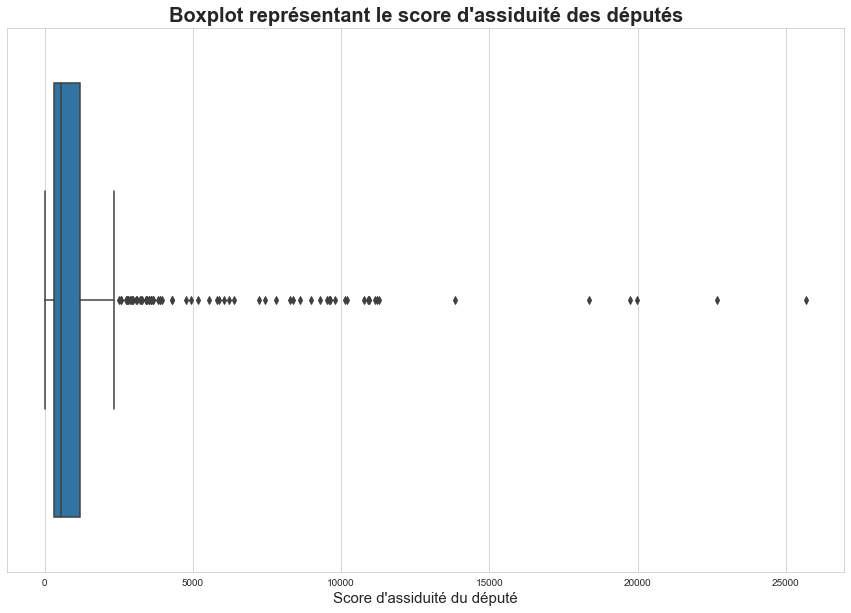

In [17]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.boxplot(x=df_new["score_assiduite"])
plt.xlabel("Score d'assiduité du député",size=15)
plt.title("Boxplot représentant le score d'assiduité des députés",size=20,fontweight='bold')
# Bcp de valeurs extrêmes : quelques députés se démarquent fortement par une activité très élevée, notamment en matière d'interventions dans l'hémicycle